In [1]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math

In [2]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [100]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def concat_sims(path_pref, max_seed):
    df_master = pd.read_csv(f"{path_pref}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    return df_master
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    #tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
    tmp["delta"] = tmp.groupby(["species"])["protein"].diff(periods=8)
    tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

def get_average_protein_no_delta(path, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.groupby(["time", "species"])["protein"].mean().reset_index()
    #tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

In [4]:
!mkdir ../yaml/jan-17-2024
!mkdir ../output/jan-17-2024

In [9]:
# simulation parameters 
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = [10]
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [100000.0, 500000.0, 1000000.0, 5000000.0, 10000000.0]
trna_charging_rate = 100.0
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.9, 0.1)]
ecol_mrna_composition = (0.9, 0.1)
gfp_mrna_compositions = [(0.99, 0.01), (0.9, 0.1), (0.5, 0.5), (0.1, 0.9)]
ribosome_speed = 0.1
ribosome_footprint = 15

date = "jan-17-2024"

In [10]:
for trna_prop in trna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[trna_prop, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [11]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for copy_number in gfp_transcript_copy_number:
            for binding_rate in ribosome_binding_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [16]:
ribosome_binding_rates = [100000.0, 500000.0, 1000000.0, 5000000.0]
df_master = None

for copy_number in gfp_transcript_copy_number:
    df_copy = None
    for binding_rate in ribosome_binding_rates:
        df_binding = None
        for codons in gfp_mrna_compositions:
            path = f"../output/{date}/two_codon_multi_transcript_0.9_0.1_{codons[0]}_{codons[1]}_0.9_0.1" + \
                   f"_{cellular_transcript_copy_number}_{copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_{binding_rate}_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 200, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_binding is not None:
                df_binding = df_binding.append(tmp, ignore_index=True)
            else:
                df_binding = tmp
        df_binding["gfp_rbs"] = binding_rate
        if df_copy is not None:
            df_copy = df_copy.append(df_binding, ignore_index=True)
        else:
            df_copy = df_binding
    df_copy["copy_number"] = copy_number
    if df_master is not None:
        df_master = df_master.append(df_copy, ignore_index=True)
    else:
        df_master = df_copy

df_master = df_master[(df_master.time == 200.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)
df_master

/tmp/ipykernel_3447064/601170023.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master["codon"] = df_master["codon"].div(1).round(1)


,time,species,protein,delta,codon,gfp_rbs,copy_number
9,200.0,ATA_charged,132.666667,0.000000,1.0,100000.0,10
10,200.0,ATA_uncharged,17.333333,0.000000,1.0,100000.0,10
11,200.0,GFP,139.666667,27.000000,1.0,100000.0,10
12,200.0,TTT_charged,1199.333333,-3.333333,1.0,100000.0,10
13,200.0,TTT_uncharged,150.666667,3.333333,1.0,100000.0,10
...,...,...,...,...,...,...,...
283,200.0,TTT_uncharged,67.333333,-0.333333,0.1,5000000.0,10
284,200.0,__GFP_rbs,5.000000,-2.000000,0.1,5000000.0,10
285,200.0,__cellularProtein_rbs,50.000000,0.666667,0.1,5000000.0,10
286,200.0,free ribosome,13.333333,2.000000,0.1,5000000.0,10


In [17]:
df = df_master[(df_master.copy_number == 10)]
df["gfp_rbs_foldx"] = df["gfp_rbs"] / ecol_rbs_rate
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df = df.pivot_table(index=['gfp_rbs_foldx', 'codon'], columns='species', values='protein')
df

species              ATA_charged  ATA_uncharged          GFP  TTT_charged  \
gfp_rbs_foldx codon                                                         
1.0           0.1     133.000000      17.000000   120.333333  1203.666667   
              0.5     130.666667      19.333333   122.000000  1190.000000   
              0.9     130.333333      19.666667   142.666667  1199.000000   
              1.0     132.666667      17.333333   139.666667  1199.333333   
5.0           0.1     126.333333      23.666667   457.666667  1213.333333   
              0.5     125.666667      24.333333   555.666667  1206.666667   
              0.9     131.333333      18.666667   626.333333  1206.000000   
              1.0     135.000000      15.000000   697.666667  1189.000000   
10.0          0.1     119.000000      31.000000   707.333333  1234.333333   
              0.5     135.000000      15.000000   909.666667  1218.000000   
              0.9     133.666667      16.333333  1182.333333  1196.333333   
              1.0     136.333333      13.666667  1308.666667  1181.000000   
50.0          0.1     125.666667      24.333333  1345.666667  1282.666667   
              0.5     125.666667      24.333333  2027.000000  1253.333333   
              0.9     131.333333      18.666667  3619.333333  1180.000000   
              1.0     135.666667      14.333333  4666.666667  1145.333333   

species              TTT_uncharged  __GFP_rbs  __cellularProtein_rbs  \
gfp_rbs_foldx codon                                                    
1.0           0.1       146.333333  10.000000              49.333333   
              0.5       160.000000  10.000000              49.333333   
              0.9       151.000000  10.000000              49.000000   
              1.0       150.666667  10.000000              48.666667   
5.0           0.1       136.666667   9.333333              48.333333   
              0.5       143.333333   9.333333              49.000000   
              0.9       144.000000  10.000000              49.333333   
              1.0       161.000000   9.000000              48.333333   
10.0          0.1       115.666667   9.000000              50.000000   
              0.5       132.000000   8.666667              49.666667   
              0.9       153.666667  10.000000              48.333333   
              1.0       169.000000   9.000000              49.000000   
50.0          0.1        67.333333   5.000000              50.000000   
              0.5        96.666667   6.333333              50.000000   
              0.9       170.000000   8.000000              49.666667   
              1.0       204.666667   9.666667              49.333333   

species              cellularProtein  free ribosome  
gfp_rbs_foldx codon                                  
1.0           0.1        3157.333333      36.000000  
              0.5        3214.000000      31.333333  
              0.9        3270.000000      35.000000  
              1.0        3288.333333      39.000000  
5.0           0.1        2734.333333      25.333333  
              0.5        2888.666667      28.000000  
              0.9        3148.333333      33.333333  
              1.0        3202.666667      29.000000  
10.0          0.1        2391.000000      25.666667  
              0.5        2609.666667      27.333333  
              0.9        3003.000000      30.666667  
              1.0        3112.333333      30.000000  
50.0          0.1        1384.000000      13.333333  
              0.5        1553.666667      14.333333  
              0.9        2298.666667      24.333333  
              1.0        2569.333333      22.333333

In [18]:
df["TTT_charged"] = df["TTT_charged"] / 1350
df["ATA_charged"] = df["ATA_charged"] / 150
df["free ribosome"] = df["free ribosome"] / 300

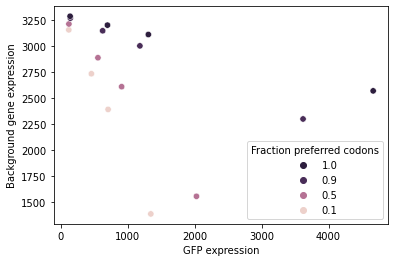

In [19]:
sns.scatterplot(data=df, x = "GFP", y = "cellularProtein", hue = "codon", s=40)
#plt.xscale("log")
plt.xlabel("GFP expression")
plt.ylabel("Background gene expression")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower right")

In [32]:
# simulation parameters 
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = [10]
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [100000.0, 250000.0, 500000.0, 1000000.0, 5000000.0]
trna_charging_rate = 500.0
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.9, 0.1)]
ecol_mrna_composition = (0.9, 0.1)
gfp_mrna_compositions = [(0.99, 0.01), (0.9, 0.1), (0.5, 0.5), (0.1, 0.9)]
ribosome_speed = 0.1
ribosome_footprint = 15

date = "jan-17-a-2024"

In [119]:
# simulation parameters 
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = [10]
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [100000.0, 250000.0, 500000.0, 1000000.0, 2500000.0]
trna_charging_rate = 50.0 # Even lower charging rate?
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.9, 0.1)]
ecol_mrna_composition = (0.9, 0.1)
gfp_mrna_compositions = [(0.99, 0.01), (0.9, 0.1), (0.5, 0.5), (0.1, 0.9)]
ribosome_speed = 0.1
ribosome_footprint = 15

date = "jan-17-b-2024"

In [49]:
# simulation parameters 
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = [10]
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 500000.0
ribosome_binding_rates = [100000.0, 250000.0, 500000.0, 1000000.0, 2500000.0]
trna_charging_rate = 50.0 # Even lower charging rate?
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.9, 0.1)]
ecol_mrna_composition = (0.9, 0.1)
gfp_mrna_compositions = [(0.99, 0.01), (0.9, 0.1), (0.5, 0.5), (0.1, 0.9)]
ribosome_speed = 0.1
ribosome_footprint = 15

date = "jan-17-c-2024"

In [59]:
# simulation parameters 
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = [10]
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 500000.0
ribosome_binding_rates = [5000000.0, 7500000.0]
trna_charging_rate = 50.0 # Even lower charging rate?
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.9, 0.1)]
ecol_mrna_composition = (0.9, 0.1)
gfp_mrna_compositions = [(0.99, 0.01), (0.9, 0.1), (0.5, 0.5), (0.1, 0.9)]
ribosome_speed = 0.1
ribosome_footprint = 15

date = "jan-17-c-2024"

In [69]:
# simulation parameters 
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = [10]
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 500000.0
ribosome_binding_rates = [100000.0, 250000.0, 500000.0, 1000000.0, 2500000.0, 5000000.0, 7500000.0]
trna_charging_rate = 10.0 # Even lower charging rate?
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.9, 0.1)]
ecol_mrna_composition = (0.9, 0.1)
gfp_mrna_compositions = [(0.99, 0.01), (0.9, 0.1), (0.5, 0.5), (0.1, 0.9)]
ribosome_speed = 0.1
ribosome_footprint = 15

date = "jan-17-d-2024"

In [79]:
# simulation parameters 
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = [20, 50]
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 500000.0
ribosome_binding_rates = [100000.0, 250000.0, 500000.0, 1000000.0, 2500000.0, 5000000.0, 7500000.0]
trna_charging_rate = 10.0 # Even lower charging rate?
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.9, 0.1)]
ecol_mrna_composition = (0.9, 0.1)
gfp_mrna_compositions = [(0.99, 0.01), (0.9, 0.1), (0.5, 0.5), (0.1, 0.9)]
ribosome_speed = 0.1
ribosome_footprint = 15

date = "jan-17-d-2024"

In [31]:
!mkdir ../output/jan-17-a-2024

In [39]:
!mkdir ../output/jan-17-b-2024

In [50]:
!mkdir ../output/jan-17-c-2024

In [70]:
!mkdir ../output/jan-17-d-2024

In [80]:
configs = os.listdir(f"../yaml/jan-17-2024")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for copy_number in gfp_transcript_copy_number:
            for binding_rate in ribosome_binding_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/jan-17-2024/{config} {seed} {cellular_transcript_copy_number} {copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [120]:
#ribosome_binding_rates = [100000.0, 250000.0, 500000.0, 1000000.0, 2500000.0, 5000000.0, 7500000.0]
#gfp_transcript_copy_number = [10, 20, 50]

df_master = None

for copy_number in gfp_transcript_copy_number:
    df_copy = None
    for binding_rate in ribosome_binding_rates:
        df_binding = None
        for codons in gfp_mrna_compositions:
            path = f"../output/{date}/two_codon_multi_transcript_0.9_0.1_{codons[0]}_{codons[1]}_0.9_0.1" + \
                   f"_{cellular_transcript_copy_number}_{copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_{binding_rate}_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 200, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_binding is not None:
                df_binding = df_binding.append(tmp, ignore_index=True)
            else:
                df_binding = tmp
        df_binding["gfp_rbs"] = binding_rate
        if df_copy is not None:
            df_copy = df_copy.append(df_binding, ignore_index=True)
        else:
            df_copy = df_binding
    df_copy["copy_number"] = copy_number
    if df_master is not None:
        df_master = df_master.append(df_copy, ignore_index=True)
    else:
        df_master = df_copy

df_master = df_master[(df_master.time == 200.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)
df_master

/tmp/ipykernel_3447064/1584340.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
/tmp/ipykernel_3447064/851225652.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master["codon"] = df_master["codon"].div(1).round(1)


,time,species,protein,ribo_density,delta,codon,gfp_rbs,copy_number
9,200.0,ATA_charged,121.333333,0.000000,1.333333,1.0,100000.0,10
10,200.0,ATA_uncharged,28.666667,0.000000,-1.333333,1.0,100000.0,10
11,200.0,GFP,122.333333,0.133333,24.666667,1.0,100000.0,10
12,200.0,TTT_charged,1059.000000,0.000000,-5.333333,1.0,100000.0,10
13,200.0,TTT_uncharged,291.000000,0.000000,5.333333,1.0,100000.0,10
...,...,...,...,...,...,...,...,...
355,200.0,TTT_uncharged,135.333333,0.000000,-16.666667,0.1,2500000.0,10
356,200.0,__GFP_rbs,7.666667,0.000000,0.333333,0.1,2500000.0,10
357,200.0,__cellularProtein_rbs,50.000000,0.000000,0.333333,0.1,2500000.0,10
358,200.0,free ribosome,15.666667,0.000000,-1.000000,0.1,2500000.0,10


In [121]:
df = df_master[(df_master.copy_number == 10)]
df["gfp_rbs_foldx"] = df["gfp_rbs"] / ecol_rbs_rate
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df = df.pivot_table(index=['gfp_rbs_foldx', 'codon'], columns='species', values='protein')
df

species              ATA_charged  ATA_uncharged          GFP  TTT_charged  \
gfp_rbs_foldx codon                                                         
1.0           0.1     116.000000      34.000000   104.000000  1103.333333   
              0.5     117.666667      32.333333   110.666667  1081.000000   
              0.9     116.000000      34.000000   117.666667  1076.000000   
              1.0     121.333333      28.666667   122.333333  1059.000000   
2.5           0.1     116.666667      33.333333   231.000000  1079.000000   
              0.5     118.333333      31.666667   265.333333  1089.000000   
              0.9     115.666667      34.333333   297.333333  1060.333333   
              1.0     114.333333      35.666667   304.000000  1050.333333   
5.0           0.1     115.000000      35.000000   402.000000  1123.666667   
              0.5     114.333333      35.666667   482.333333  1104.666667   
              0.9     122.666667      27.333333   584.333333  1055.000000   
              1.0     119.000000      31.000000   599.000000  1062.666667   
10.0          0.1     107.000000      43.000000   615.000000  1161.000000   
              0.5     109.666667      40.333333   799.333333  1114.666667   
              0.9     118.000000      32.000000  1080.666667  1069.000000   
              1.0     117.000000      33.000000  1178.000000  1056.666667   
25.0          0.1     102.000000      48.000000   909.333333  1214.666667   
              0.5     103.333333      46.666667  1328.333333  1155.333333   
              0.9     120.000000      30.000000  2122.666667  1070.000000   
              1.0     124.666667      25.333333  2550.666667  1017.333333   

species              TTT_uncharged  __GFP_rbs  __cellularProtein_rbs  \
gfp_rbs_foldx codon                                                    
1.0           0.1       246.666667   9.333333              49.666667   
              0.5       269.000000  10.000000              49.333333   
              0.9       274.000000  10.000000              48.666667   
              1.0       291.000000  10.000000              48.666667   
2.5           0.1       271.000000   9.000000              49.666667   
              0.5       261.000000   9.000000              49.000000   
              0.9       289.666667   9.666667              48.666667   
              1.0       299.666667   9.666667              49.666667   
5.0           0.1       226.333333   9.000000              49.000000   
              0.5       245.333333   9.000000              49.000000   
              0.9       295.000000   9.333333              49.333333   
              1.0       287.333333   9.666667              50.000000   
10.0          0.1       189.000000   8.000000              49.666667   
              0.5       235.333333   8.666667              49.000000   
              0.9       281.000000   8.666667              49.000000   
              1.0       293.333333  10.000000              49.000000   
25.0          0.1       135.333333   7.666667              50.000000   
              0.5       194.666667   8.666667              49.666667   
              0.9       280.000000   8.666667              50.000000   
              1.0       332.666667   8.666667              49.000000   

species              cellularProtein  free ribosome  
gfp_rbs_foldx codon                                  
1.0           0.1        2844.333333      30.333333  
              0.5        2894.333333      30.666667  
              0.9        2945.666667      31.666667  
              1.0        2956.000000      30.000000  
2.5           0.1        2685.333333      36.000000  
              0.5        2779.666667      25.666667  
              0.9        2900.000000      32.000000  
              1.0        2936.000000      26.666667  
5.0           0.1        2443.333333      29.666667  
              0.5        2594.666667      24.000000  
              0.9        2827.000000      29.000000  
              1.0 

In [122]:
df["TTT_charged"] = df["TTT_charged"] / 1350
df["ATA_charged"] = df["ATA_charged"] / 150
df["free ribosome"] = df["free ribosome"] / 300

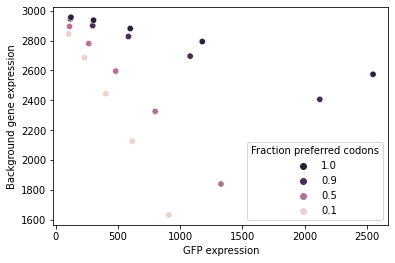

In [123]:
sns.scatterplot(data=df, x = "GFP", y = "cellularProtein", hue = "codon", s=40)
#plt.xscale("log")
plt.xlabel("GFP expression")
plt.ylabel("Background gene expression")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower right")

In [117]:
df_ribo = df_master[(df_master.copy_number == 10)]
df_ribo["gfp_rbs_foldx"] = df_ribo["gfp_rbs"] / ecol_rbs_rate
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df_ribo = df_ribo.pivot_table(index=['gfp_rbs_foldx', 'codon'], columns='species', values='ribo_density')

/tmp/ipykernel_3447064/2065313003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ribo["gfp_rbs_foldx"] = df_ribo["gfp_rbs"] / ecol_rbs_rate


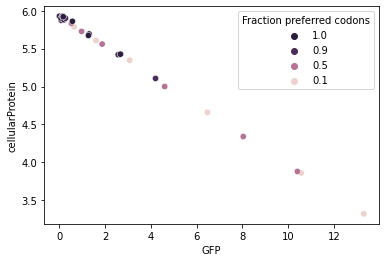

In [118]:
sns.scatterplot(data=df_ribo, x = "GFP", y = "cellularProtein", hue = "codon", s=40)
#plt.xscale("log")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="upper right")

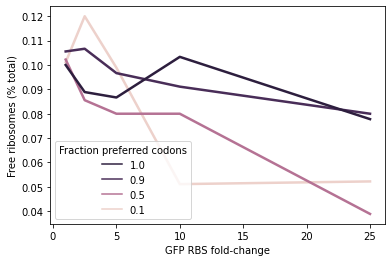

In [124]:
g = sns.lineplot(data=df, x = "gfp_rbs_foldx", y = "free ribosome", hue = "codon", linewidth=2.5)
#plt.xscale("log")
plt.xlabel("GFP RBS fold-change")
plt.ylabel("Free ribosomes (% total)")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower left")
#g.set_xticklabels(['0', '0', '2', '4', '6', '8', '10'])

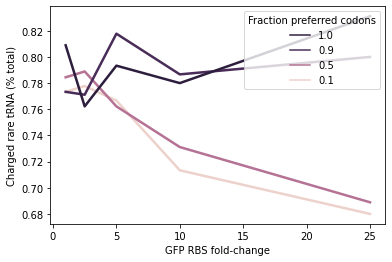

In [125]:
g = sns.lineplot(data=df, x = "gfp_rbs_foldx", y = "ATA_charged", hue = "codon", linewidth=2.5)
#plt.xscale("log")
plt.xlabel("GFP RBS fold-change")
plt.ylabel("Charged rare tRNA (% total)")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="upper right")
#g.set_xticklabels(['0', '0', '2', '4', '6', '8', '10'])

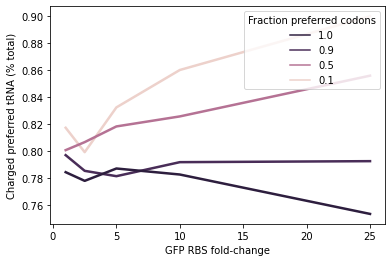

In [126]:
g = sns.lineplot(data=df, x = "gfp_rbs_foldx", y = "TTT_charged", hue = "codon", linewidth=2.5)
#plt.xscale("log")
plt.xlabel("GFP RBS fold-change")
plt.ylabel("Charged preferred tRNA (% total)")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="upper right")
#g.set_xticklabels(['0', '0', '2', '4', '6', '8', '10'])

In [131]:
# simulation parameters 
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = [10]
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [100000.0, 250000.0, 500000.0, 750000.0, 1000000.0, 2500000.0]
trna_charging_rate = 50.0 
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.9, 0.1)]
ecol_mrna_composition = (0.7, 0.3) # Making e. coli codon usage less optimal
gfp_mrna_compositions = [(0.99, 0.01), (0.9, 0.1), (0.5, 0.5), (0.1, 0.9)]
ribosome_speed = 0.1
ribosome_footprint = 15

date = "jan-18-2024"

In [182]:
# simulation parameters 
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = [10]
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 100000.0
#ribosome_binding_rates = [100000.0, 250000.0, 500000.0, 750000.0, 1000000.0, 2500000.0]
ribosome_binding_rates = [5000000.0, 7500000.0, 10000000.0, 25000000.0]
trna_charging_rate = 100.0 
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.9, 0.1)]
ecol_mrna_composition = (0.7, 0.3) # Making e. coli codon usage less optimal
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.1, 0.9)]
ribosome_speed = 0.5
ribosome_footprint = 15

date = "jan-19-2024"

In [133]:
!mkdir ../output/jan-18-2024
!mkdir ../yaml/jan-18-2024

mkdir: cannot create directory ‘../output/jan-18-2024’: File exists


In [146]:
!mkdir ../output/jan-19-2024
!mkdir ../yaml/jan-19-2024

In [183]:
for trna_prop in trna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol_mrna_composition, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [185]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for copy_number in gfp_transcript_copy_number:
            for binding_rate in ribosome_binding_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [150]:
#ribosome_binding_rates = [100000.0, 250000.0, 500000.0, 1000000.0, 2500000.0, 5000000.0, 7500000.0]
#gfp_transcript_copy_number = [10, 20, 50]

df_master = None

for copy_number in gfp_transcript_copy_number:
    df_copy = None
    for binding_rate in ribosome_binding_rates:
        df_binding = None
        for codons in gfp_mrna_compositions:
            path = f"../output/{date}/two_codon_multi_transcript_0.7_0.3_{codons[0]}_{codons[1]}_0.9_0.1" + \
                   f"_{cellular_transcript_copy_number}_{copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_{binding_rate}_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 200, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_binding is not None:
                df_binding = df_binding.append(tmp, ignore_index=True)
            else:
                df_binding = tmp
        df_binding["gfp_rbs"] = binding_rate
        if df_copy is not None:
            df_copy = df_copy.append(df_binding, ignore_index=True)
        else:
            df_copy = df_binding
    df_copy["copy_number"] = copy_number
    if df_master is not None:
        df_master = df_master.append(df_copy, ignore_index=True)
    else:
        df_master = df_copy

df_master = df_master[(df_master.time == 200.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)
df_master

/tmp/ipykernel_3447064/1584340.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
/tmp/ipykernel_3447064/1926090529.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master["codon"] = df_master["codon"].div(1).round(1)


,time,species,protein,ribo_density,delta,codon,gfp_rbs,copy_number
9,200.0,ATA_charged,79.000000,0.000000,3.333333,0.9,100000.0,10
10,200.0,ATA_uncharged,71.000000,0.000000,-3.333333,0.9,100000.0,10
11,200.0,GFP,211.666667,0.066667,40.333333,0.9,100000.0,10
12,200.0,TTT_charged,1175.000000,0.000000,3.666667,0.9,100000.0,10
13,200.0,TTT_uncharged,175.000000,0.000000,-3.666667,0.9,100000.0,10
...,...,...,...,...,...,...,...,...
427,200.0,TTT_uncharged,107.333333,0.000000,-10.333333,0.1,2500000.0,10
428,200.0,__GFP_rbs,8.666667,0.000000,0.333333,0.1,2500000.0,10
429,200.0,__cellularProtein_rbs,49.333333,0.000000,0.333333,0.1,2500000.0,10
430,200.0,free ribosome,30.000000,0.000000,4.000000,0.1,2500000.0,10


In [151]:
df = df_master[(df_master.copy_number == 10)]
df["gfp_rbs_foldx"] = df["gfp_rbs"] / ecol_rbs_rate
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df = df.pivot_table(index=['gfp_rbs_foldx', 'codon'], columns='species', values='protein')
df

species              ATA_charged  ATA_uncharged          GFP  TTT_charged  \
gfp_rbs_foldx codon                                                         
1.0           0.1      76.666667      73.333333   180.666667  1168.333333   
              0.5      65.666667      84.333333   210.333333  1182.000000   
              0.7      73.333333      76.666667   205.000000  1172.000000   
              0.9      79.000000      71.000000   211.666667  1175.000000   
2.5           0.1      67.000000      83.000000   457.333333  1174.666667   
              0.5      74.333333      75.666667   500.666667  1176.333333   
              0.7      72.333333      77.666667   523.333333  1171.333333   
              0.9      79.000000      71.000000   508.666667  1178.333333   
5.0           0.1      67.666667      82.333333   831.000000  1201.000000   
              0.5      68.333333      81.666667   910.000000  1179.666667   
              0.7      74.666667      75.333333   978.333333  1146.333333   
              0.9      66.666667      83.333333  1038.666667  1163.333333   
7.5           0.1      72.000000      78.000000  1108.000000  1191.000000   
              0.5      67.000000      83.000000  1354.000000  1175.000000   
              0.7      72.666667      77.333333  1413.333333  1183.666667   
              0.9      74.666667      75.333333  1523.666667  1167.000000   
10.0          0.1      71.000000      79.000000  1417.000000  1200.333333   
              0.5      69.333333      80.666667  1744.333333  1180.333333   
              0.7      69.666667      80.333333  1876.666667  1189.000000   
              0.9      69.333333      80.666667  1973.000000  1136.666667   
25.0          0.1      68.333333      81.666667  2416.000000  1242.666667   
              0.5      70.000000      80.000000  3354.000000  1192.666667   
              0.7      71.666667      78.333333  3837.666667  1166.000000   
              0.9      68.333333      81.666667  4503.666667  1117.333333   

species              TTT_uncharged  __GFP_rbs  __cellularProtein_rbs  \
gfp_rbs_foldx codon                                                    
1.0           0.1       181.666667  10.000000              48.333333   
              0.5       168.000000  10.000000              48.333333   
              0.7       178.000000  10.000000              47.666667   
              0.9       175.000000  10.000000              47.333333   
2.5           0.1       175.333333   9.333333              47.333333   
              0.5       173.666667   9.666667              48.000000   
              0.7       178.666667  10.000000              48.000000   
              0.9       171.666667  10.000000              47.000000   
5.0           0.1       149.000000   8.666667              47.333333   
              0.5       170.333333   9.333333              48.333333   
              0.7       203.666667  10.000000              47.333333   
              0.9       186.666667   9.666667              49.000000   
7.5           0.1       159.000000   8.333333              49.666667   
              0.5       175.000000   9.666667              48.666667   
              0.7       166.333333   9.000000              47.333333   
              0.9       183.000000   9.666667              48.333333   
10.0          0.1       149.666667   8.666667              48.666667   
              0.5       169.666667   8.666667              48.000000   
              0.7       161.000000   9.666667              48.666667   
              0.9       213.333333   9.333333              48.333333   
25.0          0.1       107.333333   8.666667              49.333333   
              0.5       157.333333   9.333333              49.000000   
              0.7       184.000000   8.666667              49.666667   
              0.9       232.666667   9.666667              48.333333   

species              cellularProtein  free ribosome  
gfp_rbs_foldx codon                                  
1.0           0.

In [152]:
df["TTT_charged"] = df["TTT_charged"] / 1350
df["ATA_charged"] = df["ATA_charged"] / 150
df["free ribosome"] = df["free ribosome"] / 300

In [167]:
rcParams['figure.figsize'] = [5, 6]

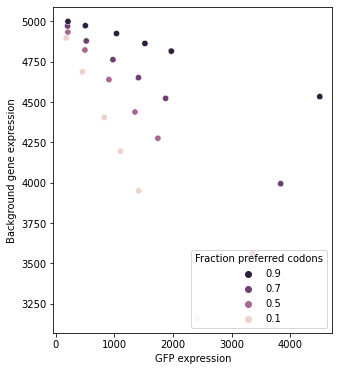

In [168]:
sns.scatterplot(data=df, x = "GFP", y = "cellularProtein", hue = "codon", s=40)
#plt.xscale("log")
plt.xlabel("GFP expression")
plt.ylabel("Background gene expression")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower right")

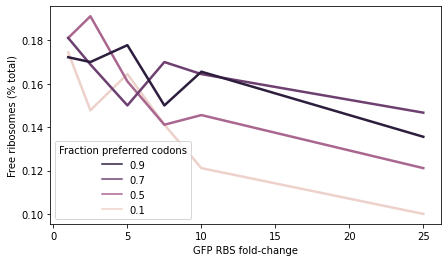

In [170]:
rcParams['figure.figsize'] = [7, 4]
g = sns.lineplot(data=df, x = "gfp_rbs_foldx", y = "free ribosome", hue = "codon", linewidth=2.5)
#plt.xscale("log")
plt.xlabel("GFP RBS fold-change")
plt.ylabel("Free ribosomes (% total)")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower left")
#g.set_xticklabels(['0', '0', '2', '4', '6', '8', '10'])

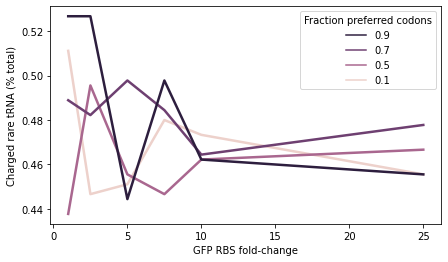

In [171]:
g = sns.lineplot(data=df, x = "gfp_rbs_foldx", y = "ATA_charged", hue = "codon", linewidth=2.5)
#plt.xscale("log")
plt.xlabel("GFP RBS fold-change")
plt.ylabel("Charged rare tRNA (% total)")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="upper right")
#g.set_xticklabels(['0', '0', '2', '4', '6', '8', '10'])

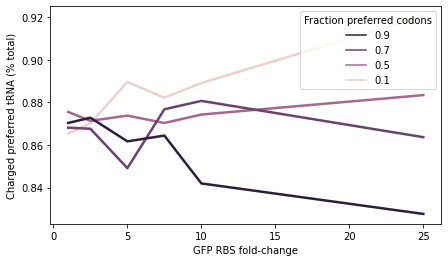

In [172]:
g = sns.lineplot(data=df, x = "gfp_rbs_foldx", y = "TTT_charged", hue = "codon", linewidth=2.5)
#plt.xscale("log")
plt.xlabel("GFP RBS fold-change")
plt.ylabel("Charged preferred tRNA (% total)")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="upper right")
#g.set_xticklabels(['0', '0', '2', '4', '6', '8', '10'])

In [173]:
df_ribo = df_master[(df_master.copy_number == 10)]
df_ribo["gfp_rbs_foldx"] = df_ribo["gfp_rbs"] / ecol_rbs_rate
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df_ribo = df_ribo.pivot_table(index=['gfp_rbs_foldx', 'codon'], columns='species', values='ribo_density')

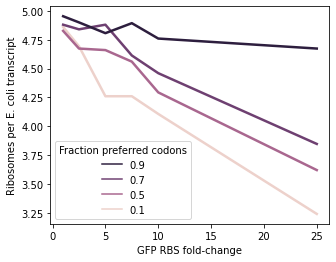

In [181]:
rcParams['figure.figsize'] = [5, 4]

sns.lineplot(data=df_ribo, x = "gfp_rbs_foldx", y = "cellularProtein", hue = "codon", linewidth=2.5)
plt.xlabel("GFP RBS fold-change")
plt.ylabel("Ribosomes per E. coli transcript")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower left")